In [1]:
from helper_DinoV2_Embeddings import *
from helper_classifier import prepare_data, get_datasets, train_model, evaluate_model
from helper_classifier import DressCategoriesDataset, ClassifierModel

root_path = f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/"

In [15]:
embeddings, df = extract_embeddings()
df, id2label, label2id = prepare_data(df, 'category')
train_dataset, test_dataset = get_datasets(df, embeddings)

Loading embeddings from disk...
14060 embeddings loaded from disk...


### Sanity Check for Embeddings: Nearest Neighbour

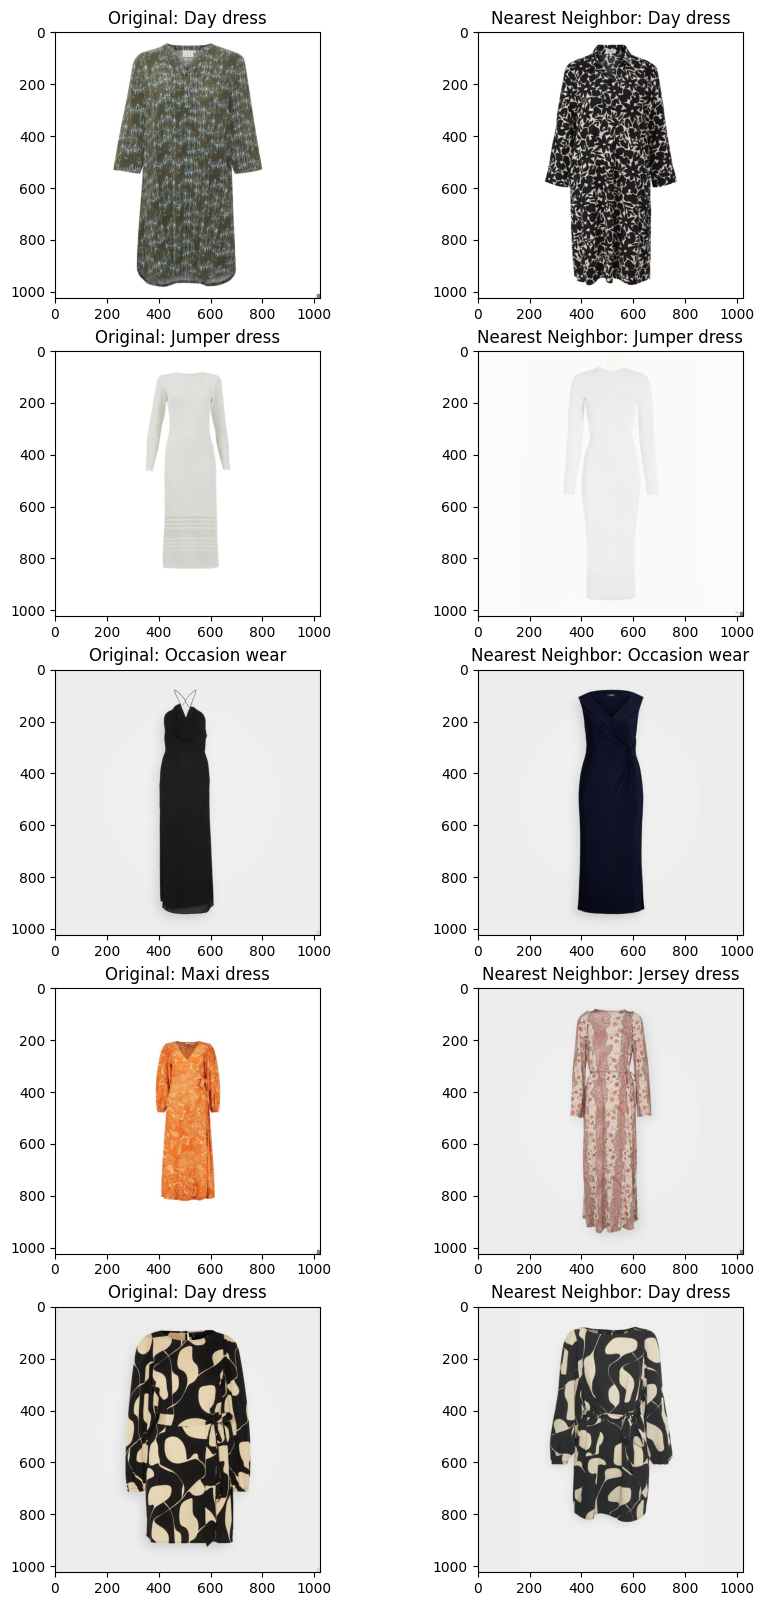

In [3]:
# Visualize Multiple articels and their nearest neighbors
import matplotlib.pyplot as plt
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
num_samples = 5

fig, axs = plt.subplots(num_samples, 2, figsize=(10, 20))
for i in range(num_samples):
    sample = df.sample(1)
    embedding = embeddings[sample.index.item(),:]
    similarity = cos(embeddings, embedding)
    second_highest = torch.argsort(similarity, descending=True)[1].item()
    second_highest_article = df.iloc[second_highest]
    img_path = f"{root_path}{sample.sku.item()}.jpg"
    img = Image.open(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f"Original: {sample.category.item()}")
    img_path = f"{root_path}{second_highest_article.sku}.jpg"
    img = Image.open(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(f"Nearest Neighbor: {second_highest_article.category}")

### Outliers

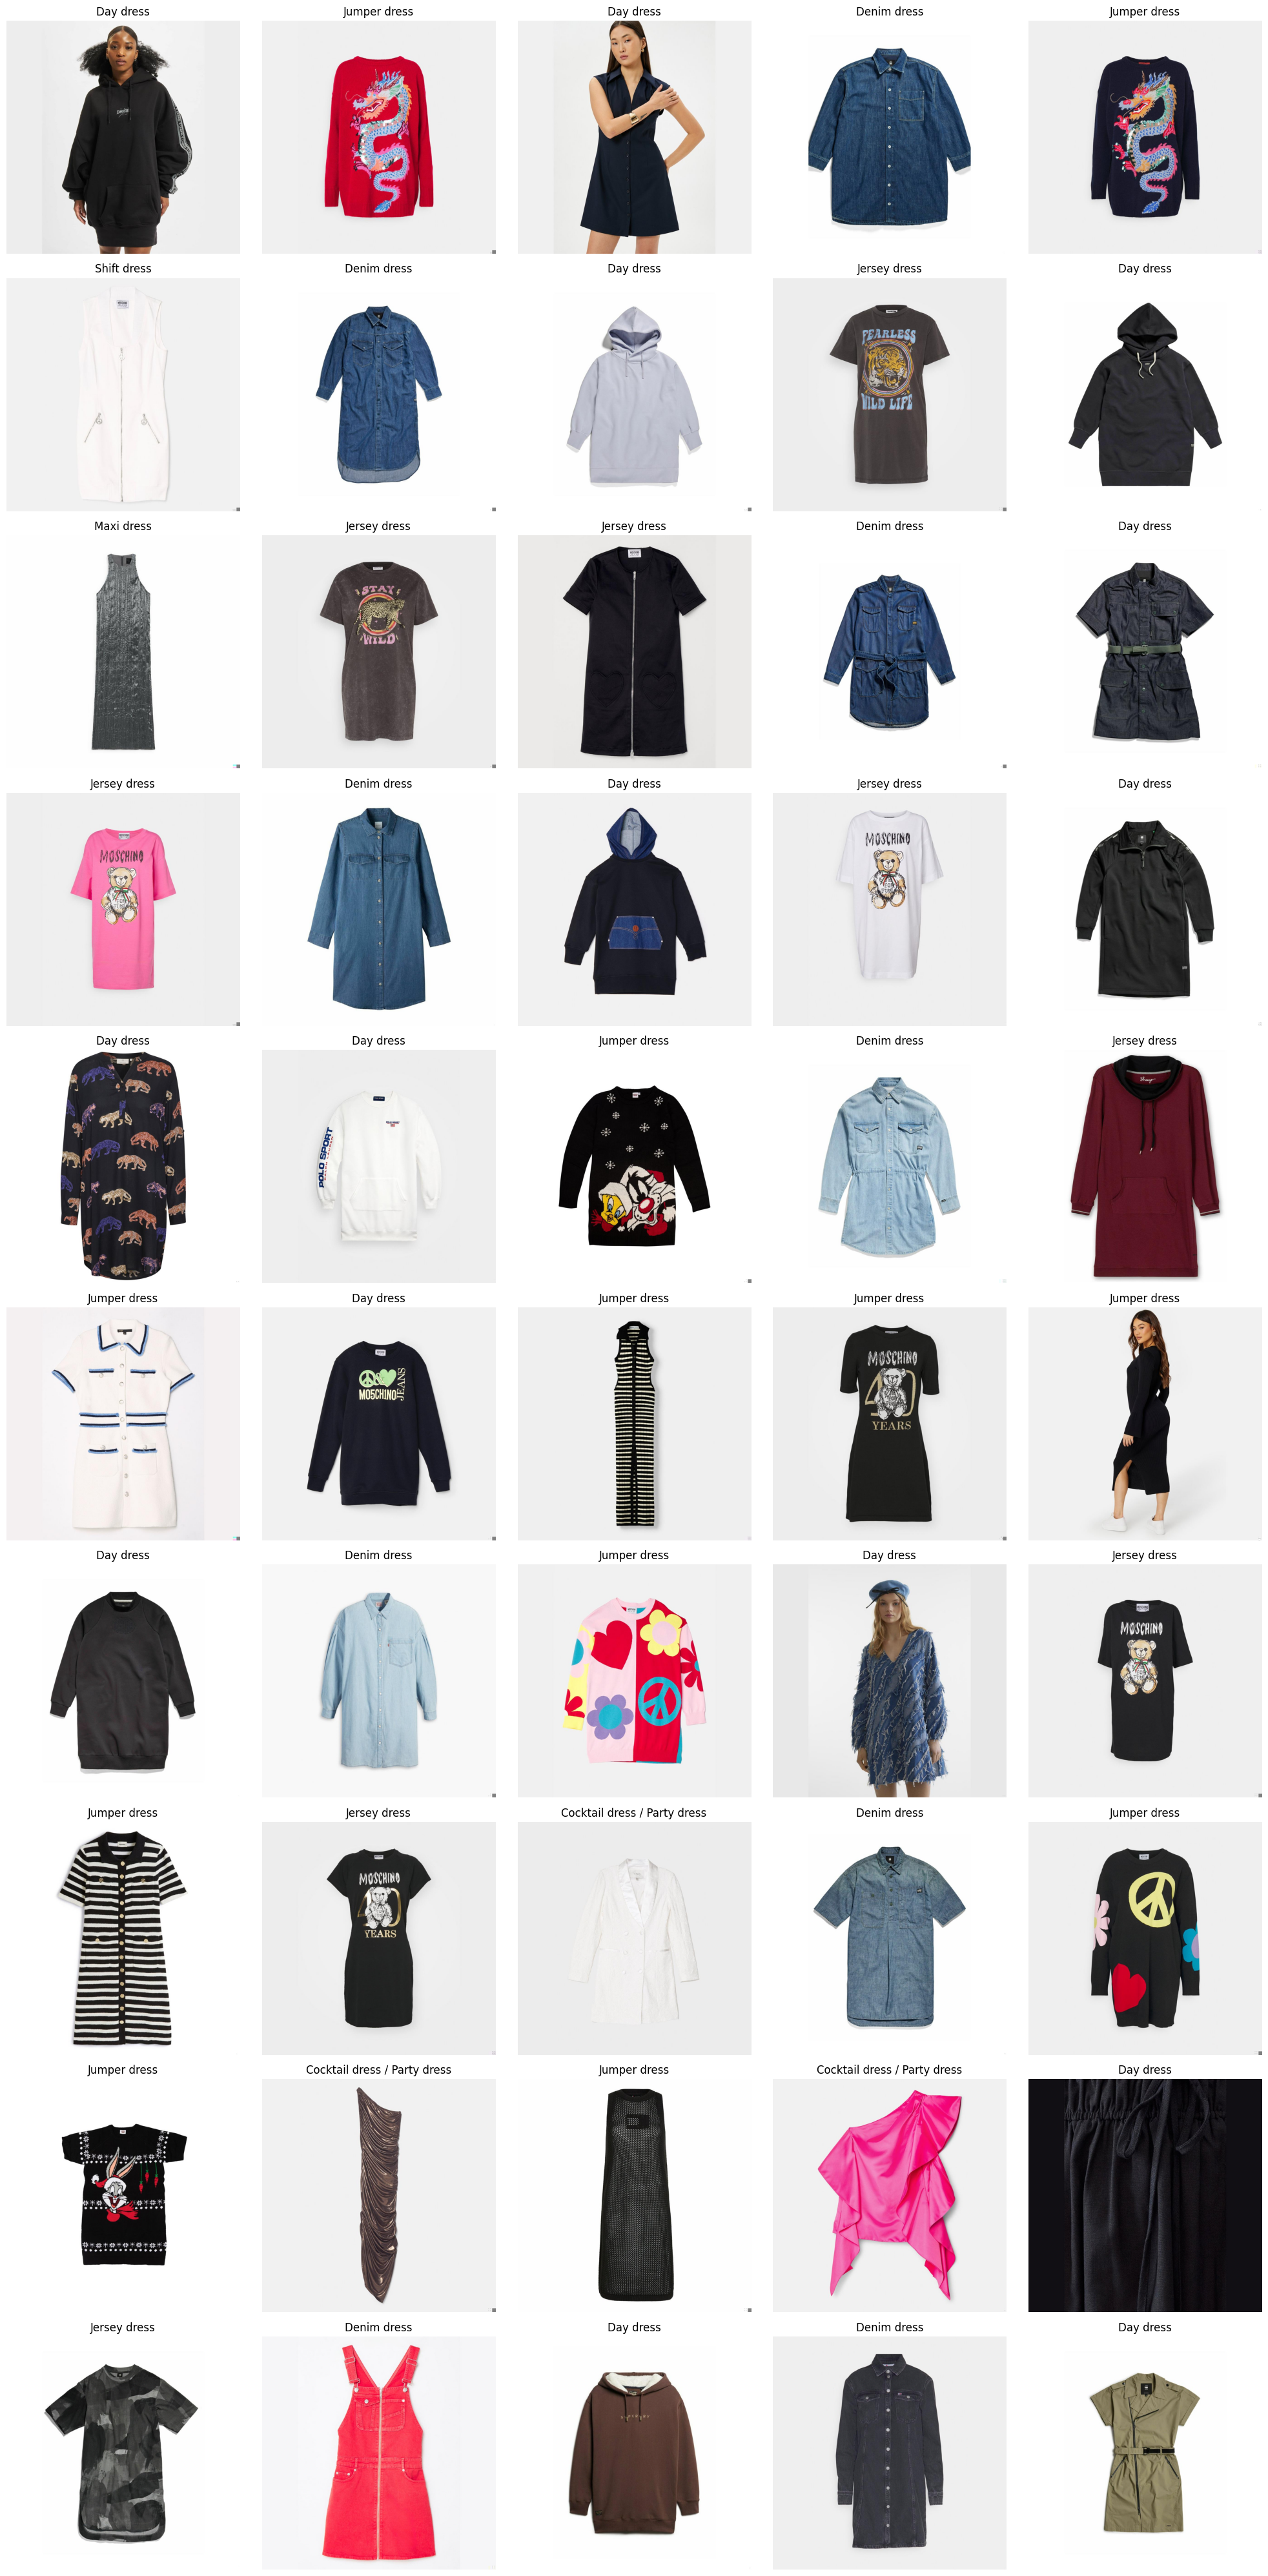

In [4]:
# Caluclate mean embedding
mean_embedding = embeddings.mean(dim=0)
# Calculate similarity of each embedding to the mean embedding
similarity = cos(embeddings, mean_embedding)
# Get index of 50 most dissimilar embeddings
dissimilar_idx = torch.argsort(similarity, descending=False)[:50]
# Get the corresponding articles
dissimilar_articles = df.iloc[dissimilar_idx]
# Plot the 50 most dissimilar articles
fig, axs = plt.subplots(10, 5, figsize=(20, 40))
for i in range(10):
    for j in range(5):
        article = dissimilar_articles.iloc[i*5+j]
        img_path = f"{root_path}{article.sku}.jpg"
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(f"{article.category}")
        axs[i, j].axis('off')
fig.tight_layout()
plt.show()

### Test some clustering algorithms

In [5]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# Assuming `embeddings` is your (14060, 768) numpy array containing image embeddings
# It's often useful to scale the data, although it might not be necessary with good embeddings
#embeddings_scaled = StandardScaler().fit_transform(embeddings)

# Compute median distance between points to help choose `eps`
dist = euclidean_distances(embeddings)
median_dist = np.median(dist)

# Initialize DBSCAN with estimated parameters
dbscan = DBSCAN(eps=20, min_samples=20)

# Fit DBSCAN on the scaled embeddings
clusters = dbscan.fit_predict(embeddings)

# Check the number of clusters formed and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')
print(f'Cluster distribution: {dict(zip(*np.unique(clusters, return_counts=True)))}')

Estimated number of clusters: 5
Estimated number of noise points: 13139
Cluster distribution: {-1: 13139, 0: 564, 1: 85, 2: 22, 3: 196, 4: 54}


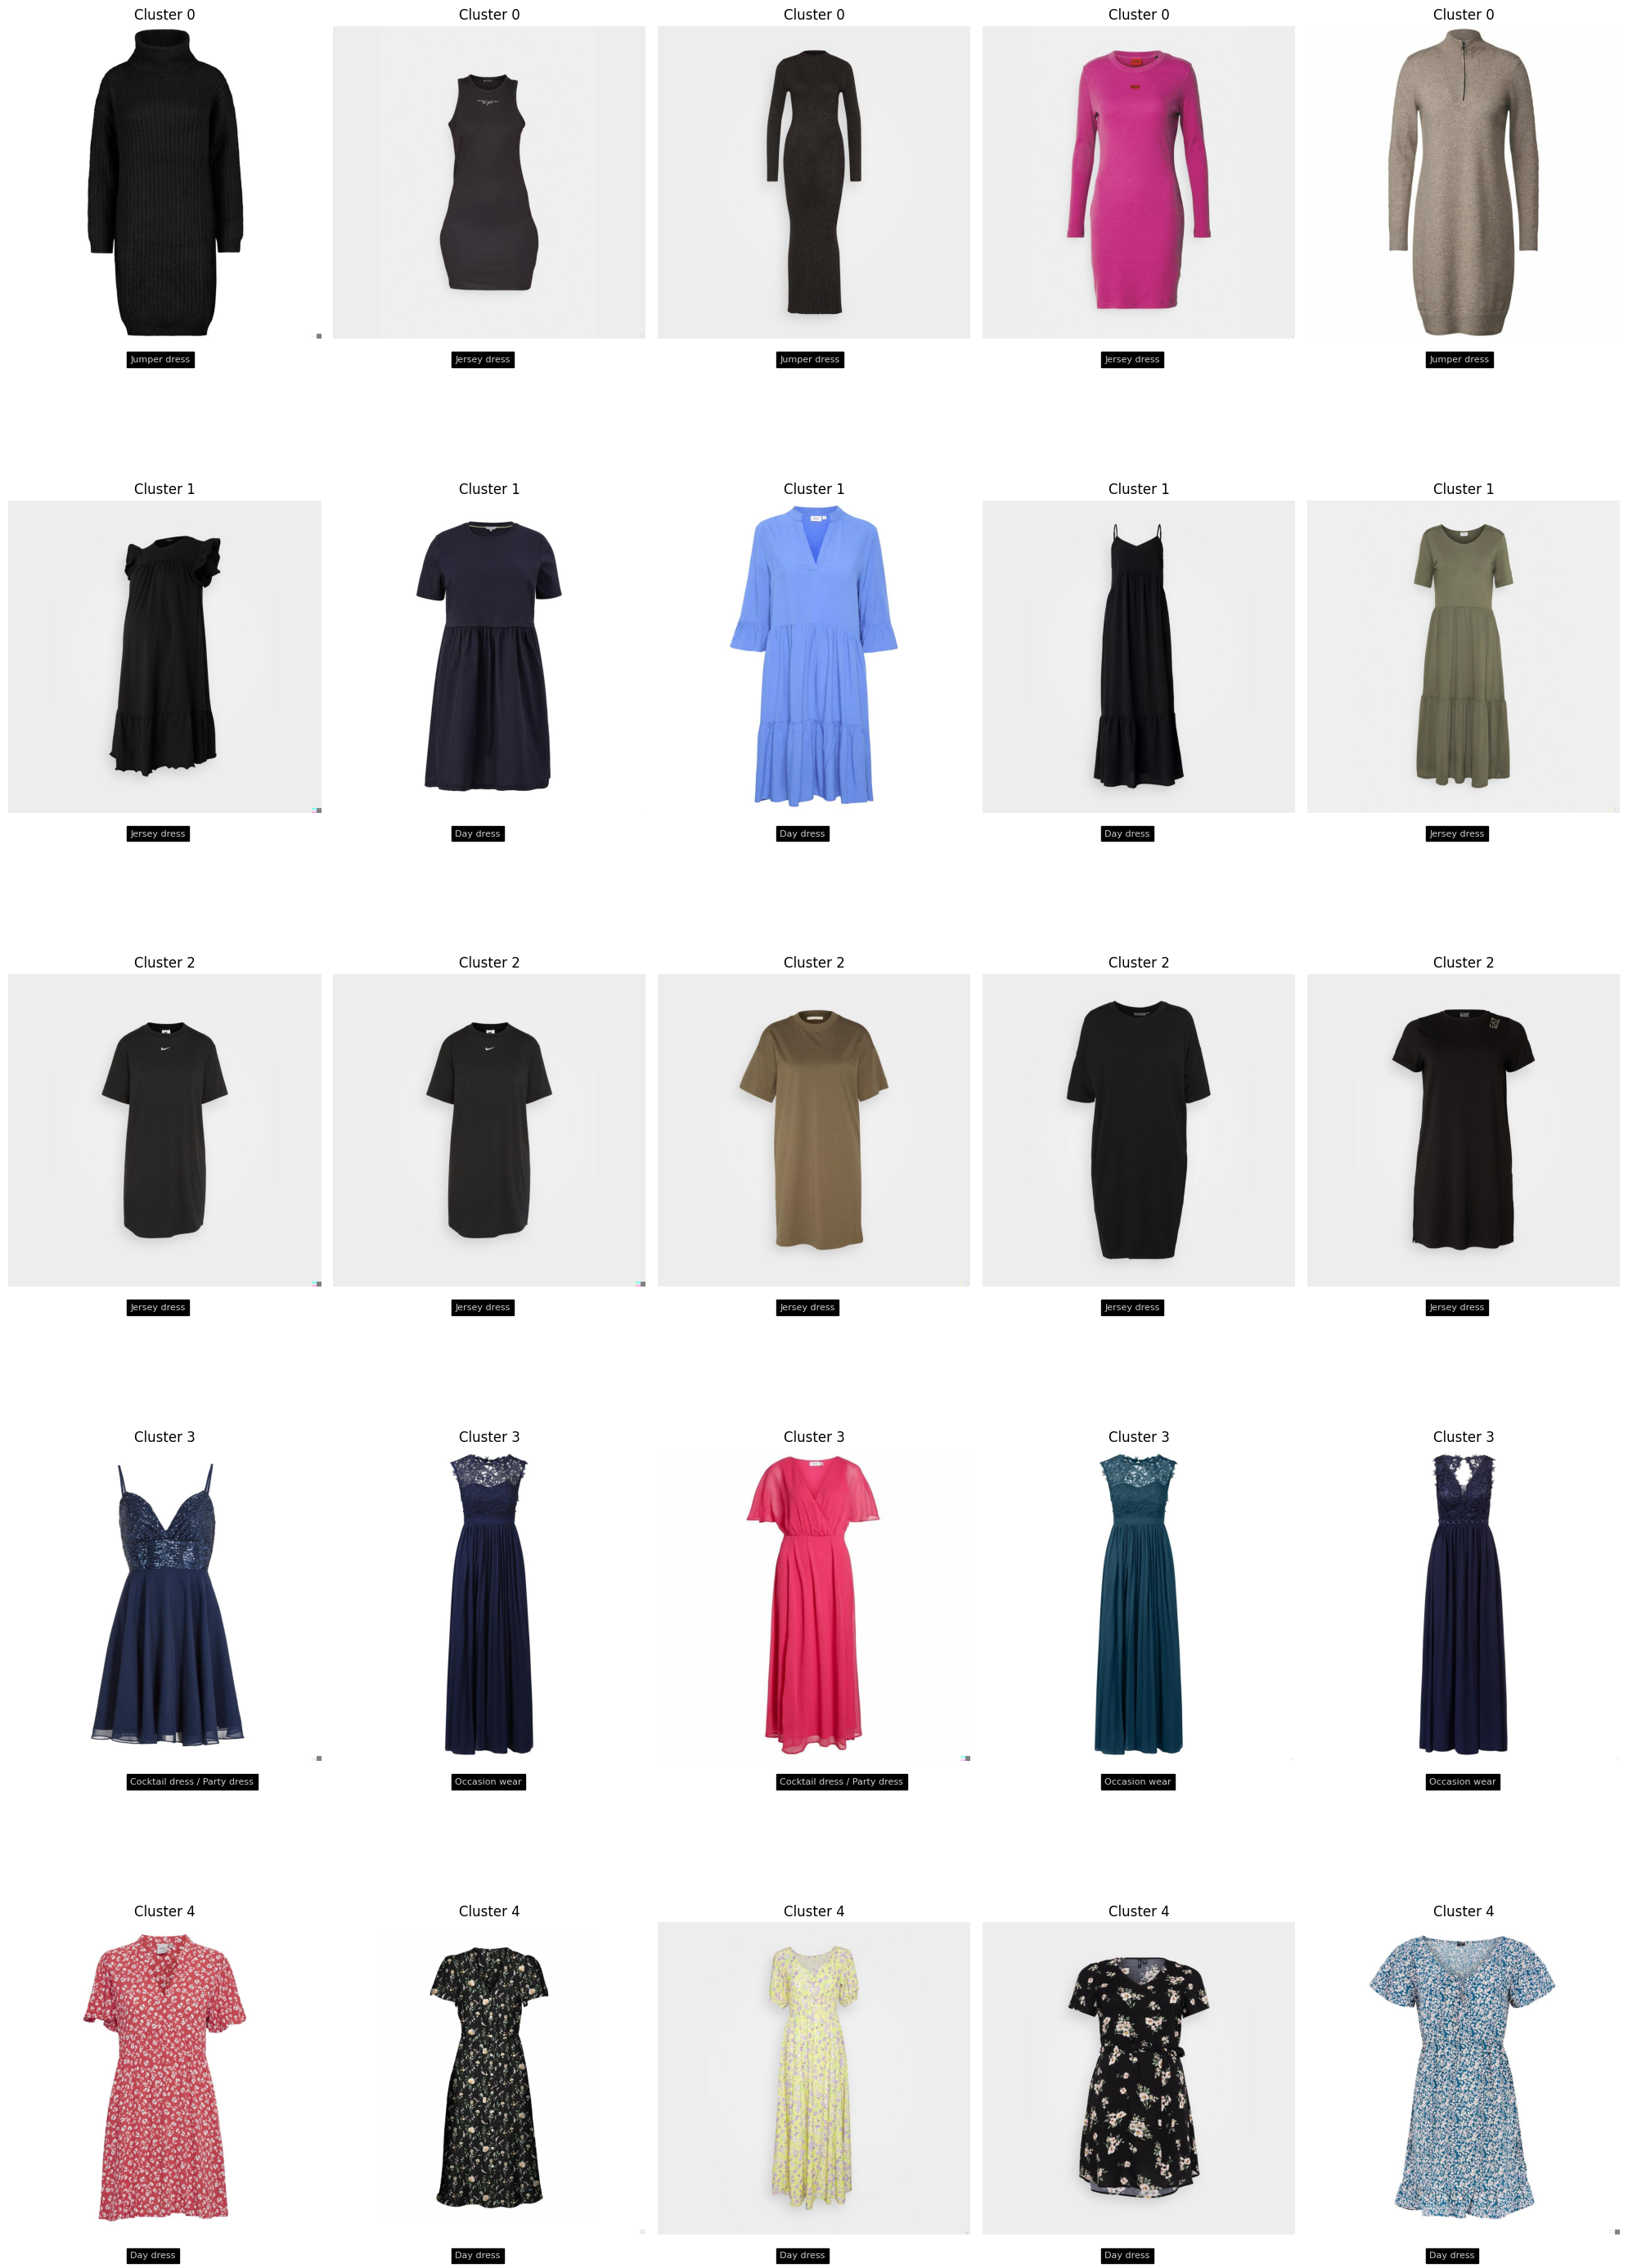

In [6]:
# Plot 5 examples from each cluster
fig, axs = plt.subplots(n_clusters, 5, figsize=(20,30))
for i in range(n_clusters):
    cluster_idx = np.where(clusters == i)[0]
    cluster_samples = df.iloc[cluster_idx]
    for j in range(5):
        article = cluster_samples.sample(1)
        img_path = f"{root_path}{article.sku.item()}.jpg"
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        #axs[i, j].set_title(f"{article.category.item()}")
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Cluster {i}")
        # Print category
        axs[i,j].text(400, 1100, f"{article.category.item()}", verticalalignment='baseline', color='white', backgroundcolor='black', fontsize=8, alpha=0.8, animated=True)

fig.tight_layout()
plt.show()

### Check class assignment based on similarity scores

In [16]:
cat_means = {}
# Compute mean embeddings for each category
for category in df.category.unique():
    category_idx = df[df.category == category].index
    category_embeddings = embeddings[category_idx]
    mean_embedding = category_embeddings.mean(dim=0)
    cat_means[category] = mean_embedding

In [17]:
for category in df.category.unique():
    df[category] = 0.0

In [19]:
for i in range(len(df)):
    embedding = embeddings[i]
    similarity = cos(embedding, torch.stack(list(cat_means.values())))
    df.iloc[i, 3:] = similarity.detach().numpy()

# Get maximum similarity category for each article
df['most_similar'] = df.iloc[:, 3:].idxmax(axis=1)

In [22]:
# Accuracy 
accuracy = (df.category == df.most_similar).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.47083926031294454


In [21]:
# Displax confustion matrix
pd.crosstab(df.category, df.most_similar)

most_similar                  Cocktail dress / Party dress  Day dress  \
category                                                                
Cocktail dress / Party dress                           433        304   
Day dress                                              299       2495   
Denim dress                                              3         41   
Jersey dress                                            66        248   
Jumper dress                                            20         49   
Maxi dress                                              29        242   
Occasion wear                                           54         23   
Shift dress                                             62         29   

most_similar                  Denim dress  Jersey dress  Jumper dress  \
category                                                                
Cocktail dress / Party dress           25            45            84   
Day dress                             176           406           479   
Denim dress                           226             8             2   
Jersey dress                           12           430           314   
Jumper dress                           33           134          1340   
Maxi dress                             73            59            51   
Occasion wear                           1             7             6   
Shift dress                            14            35           115   

most_similar                  Maxi dress  Occasion wear  Shift dress  
category                                                              
Cocktail dress / Party dress         129            380          366  
Day dress                            985            186          215  
Denim dress                            7              7           18  
Jersey dress                         250            120          350  
Jumper dress                          44             35          334  
Maxi dress                           742            210           67  
Occasion wear                         97            575           54  
Shift dress                           23             15          379